### OpenAI Trained Model Tuning on Text-Data
- ChatBot_Project_Practise_work

### Import Modules

In [1]:
import pandas as pd
import openai
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
from typing import Set
from transformers import GPT2TokenizerFast
from nltk.tokenize import sent_tokenize
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

### Define Functions

In [5]:
# Tokenz Count Function >>>>>>>>>>>>>>>>>>>>

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(tokenizer.encode(text))

# Paragraph Tokenz length >>>>>>>>>>>>>>

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 500
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i][:-1]) + "."

    return long_text

### Import Books

In [363]:
book = pd.read_csv('data.csv')

### Check tokenz and concatenation

In [364]:
short_str = ''
res = []
tokenz_res = []
for line in book['a']:
    tokenz = count_tokens(line)
    # print(tokenz)
    if tokenz < 100:
        short_str += line
        # print(short_str)
    tokenz2 = count_tokens(short_str)
    # print(tokenz2)
    if tokenz2 > 100:
        res.append(short_str)
        tokenz_res.append(tokenz2)
        short_str = ''
data_res = {
    'content' : res,
    'tokens' : tokenz_res
}   
print('completed')

completed


### Converting to DataFrame

In [365]:
new_df = pd.DataFrame(data_res)

In [366]:
new_df.to_csv('Set_Name_Here.csv',na_rep='unknown',index=False)

In [367]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  320 non-null    object
 1   tokens   320 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.1+ KB


## Load Models For Embeddings text

In [3]:
MODEL_NAME = "ada"  

DOC_EMBEDDINGS_MODEL = f"text-search-{MODEL_NAME}-doc-001"
QUERY_EMBEDDINGS_MODEL = f"text-search-{MODEL_NAME}-query-001"

### Embeding Functions

In [4]:
# ------------------- >>>>>  Text Embedding Function  <<<<< ----------------------
def get_embedding(text: str, model: str) -> list[float]:
    # print('get_embedding >>> Working')
    
    result = openai.Embedding.create(
        api_key = "Add_Your_API-Key Here",
        model=model,
        input=text
        
    )
    # time.sleep(1)
    return result["data"][0]["embedding"]

# ------------------ >>>>> Document Embedding Function <<<<< ----------------------
def get_doc_embedding(text: str) -> list[float]:
    # print('get_doc_embedding >>> Working')
    
    return get_embedding(text, DOC_EMBEDDINGS_MODEL)


# ------------------ >>>>>> Query Embedding function <<<<< -----------------------
def get_query_embedding(text: str) -> list[float]:
    print('get_query_embedding >>> Working')
    result =  get_embedding(text, QUERY_EMBEDDINGS_MODEL)
    return result

#  -------------- >>>>>>>>>>>> This one for DataFrame  <<<<<<<<< ----------------------

def compute_doc_embeddings(df: pd.DataFrame) -> dict[tuple[str, str], list[float]]:
    print('compute_doc_embeddings >>> Working')
    return { idx: get_doc_embedding(r.content.replace("\n", " ")) for idx, r in df.iterrows() }



#  --------------------- >>>>>>>> Embedding Load Function  <<<<<<<< ---------------------------
def load_embeddings(fname: str) -> dict[tuple[str, str], list[float]]:
    df = pd.read_csv(fname, header=0)  # Load a csv file here 
    max_dim = max([int(c) for c in df.columns if c != "title" and c != "heading"])
    return {(r.title, r.heading): [r[str(i)] for i in range(max_dim + 1)] for _, r in df.iterrows()}

### Load Tokenize CSV File here

In [6]:
# -------------------- >>>>>> Add CSV Book Name <<<<< ---------------
Token_file_data = pd.read_csv('Here.csv')

In [7]:
type(Token_file_data)

pandas.core.frame.DataFrame

In [9]:
need_data = Token_file_data
emb_data_book = need_data['title']
need_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    97 non-null     object
 1   content  97 non-null     object
 2   tokens   97 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


## Embedding Data 

In [10]:
embeded_data_dict = {}

In [ ]:
end_ind = 50
start_ind = 0
while start_ind <= len(need_data['content']):
    time.sleep(60)
    data = compute_doc_embeddings(need_data[start_ind:end_ind])
    time.sleep(60)
    print(start_ind,end_ind,' ---------- >>>>>>>>> Embedding completed')
    start_ind = end_ind
    if start_ind < len(need_data['content']):
        value = (len(need_data['content']) - start_ind)
        if value > 50 : 
            end_ind += 50
            # time.sleep(60)
        else:
            end_ind += value
            # time.sleep(60)
        embeded_data_dict.update(data)
    else:
        embeded_data_dict.update(data)
        break
    
    

In [25]:
len(embeded_data_dict)

97

### Converted Embedded data into DataFrame and saved in CSV Formet

In [26]:
embedding_df = pd.DataFrame(embeded_data_dict)

In [27]:
# -------------- >>> Set CSV Book Name <<< ----------------
embedding_df.to_csv('Here.csv',na_rep='unknown',index=False)

### Check Similarity of text from embedded model
- This Block is just for Fun Time

In [171]:
from openai.embeddings_utils import cosine_similarity 
 
def search_reviews(df, product_description, n=5, pprint=True):
    embedding = get_query_embedding(product_description) 
    df['similarities'] = df.apply(lambda x: cosine_similarity(x, embedding))
    res = df.sort_values('similarities', ascending=False).head(n)
    return res

In [241]:
# -------------------- >>>>>> Ask the Questions  <<<<<<< ----------------------
res = search_reviews(embedding_df, 'here', n=5)
res

get_query_embedding >>> Working
get_embedding >>> Working


,0,1,2,3,4,5,6,7,8,9,similarities
1,0.010444,-0.000873,-0.016433,-0.006732,-0.007548,-0.007801,-0.019251,-0.019283,-0.008970,-0.006380,0.434068
0,-0.011969,-0.012721,-0.001982,-0.001667,-0.005569,0.003516,-0.008790,-0.018543,0.008496,0.006119,0.404141
4,-0.002076,-0.018398,0.003608,0.008050,0.019585,-0.013821,0.000617,-0.001684,0.004514,0.011766,0.298409
5,0.016675,0.015208,0.003464,-0.002687,-0.005578,0.003711,0.000999,0.007169,-0.000119,-0.000553,0.283364
9,-0.002439,0.006916,0.010913,-0.016731,0.001728,0.005037,-0.009179,0.002241,-0.010477,-0.001754,0.269173


## Find similarity with Embedding code and comparing it with Text

In [28]:
need_data.to_csv('>>>>Add Book-Name here<<<<.csv',na_rep='unknown',index=False)

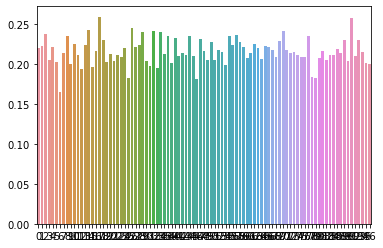

In [32]:
from openai.embeddings_utils import cosine_similarity

data_df = pd.read_csv('Add_your_Data-Book_name_Here.csv')
string_text = data_df['content']
# Load the embeddings for the text documents
embeddings = pd.read_csv('Add_Your_Embedding_book_Here.csv')
print(embeddings.shape)

# Encode the text query as a vector
question = str(input("Ask Your Question Here!! : "))
query_vector = get_embedding(question,QUERY_EMBEDDINGS_MODEL)

# Compute the cosine similarity between the query vector and the document embeddings
similarities = embeddings.apply(lambda x: cosine_similarity(x, query_vector))

# Find the indices of the most similar documents
most_similar_indices = similarities.argsort()[:len(similarities)-5:-1]

plot = sns.barplot(y=similarities, x=most_similar_indices)
# Print the text of the most similar documents

answer = ''
for index in most_similar_indices:
    answer += f"{string_text[index]}\n"
# print(answer)

### Questions And Answers From Davinci-003

In [ ]:
COMPLETIONS_MODEL = "text-davinci-003"
prompt = f' {question} ? \n{answer}'  # Answer length must under 4000 not exceed from 4096
openai.Completion.create(
    api_key = 'Add_API-Key here',
    prompt=prompt,
    temperature=0,
    max_tokens=300,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    model=COMPLETIONS_MODEL,
    
)["choices"][0]["text"].strip('\n')


Please Enter Your Question: who is bhukhosi
